# Cálculo do grau de liberação de minério de ferro 
# em imagens de microscópio ópitco

## Faz o treinamento, teste e inferência em imagens de minério de ferro utilizando algoritmo Mask RCNN para a segmentação das partícula.
## Calcula a quantidade de ferro em cada partícula com algoritmo SLIC
## Faz o cálculo do grau de liberação em cada imagem com o resultado da execução do referidos algoritmos.


### Codigo executado em ambiente Colab, em: https://colab.research.google.com/ 
### Utilizando hadware T4 GPU

# Instalação do framework Detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core, datetime
import shutil
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 2.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15528, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 15528 (delta 82), reused 185 (delta 41), pack-reused 15275
Receiving objects: 100% (15528/15528), 6.40 MiB | 17.20 MiB/s, done.
Resolving deltas: 100% (11196/11196), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 671.4 kB/s eta 0:0

In [ ]:
#Verifica se tem GPU nvidia:
!nvidia-smi

Sat Apr 13 17:05:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Definir o diretorio do projeto

In [ ]:
projectDirDrive = 'MyDrive/detectron2/mestrado/'

# Importacao de Bibliotecas Necessárias

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random, sys
from json import JSONEncoder
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from pytz import timezone


In [ ]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [ ]:
#para uso da segmentação por slic
from skimage import io, color
from skimage.transform import resize
from skimage import segmentation
from skimage.util import img_as_float
from skimage import io, color
from skimage import data
from skimage import morphology
from skimage import img_as_ubyte

In [ ]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.4 MB/s eta 0:00:00


In [ ]:
# Versões dos pacotes usados neste jupyter notebook 20/09/20223
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

torch     : 2.2.1+cu121
matplotlib: 3.7.1
detectron2: 0.6
distutils : 3.10.12
skimage   : 0.19.3
sys       : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy     : 1.25.2
json      : 2.0.9
cv2       : 4.8.0



In [ ]:
print("Python_version:", sys.version)

Python_version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


## classes

In [ ]:
class TrainProcess():
  def __init__(self):
    #define alguns valores padrão de variáveis
    self.configFileYaml = 'COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml'
    self.datasetsTrainName = 'mineral_treino'
    self.maxIter = 1000
    self.numClasses = 2
    self.saveModelOption = True  #indica se é para salvar o modelo na rede ou não
    self.destinationDir = './qualquerNome' # diretório de destino do modelo
    self.destinationDirRoot = './ouput/'
    self.destinationFile = 'model_final.pth' #novo nome do arquivo
    self.sourceFile = './output/model_final.pth' #arquivo de origem do modelo após o treinamento
    self.information = [''] # Criar uma lista de informacoes para salvar no arquivo README do diretório
    self.informationFile = 'README.txt'

  # Cria um objeto para treinamento de modelo conforme parametros de configuracao fornecidos
  def createTrainer(self, configTrain):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(configTrain['configFileYaml']))
    cfg.DATASETS.TRAIN = (configTrain['datasetsTrain'],)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(configTrain['configFileYaml'])  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
    cfg.SOLVER.MAX_ITER = configTrain['maxIter'] # default 300
    cfg.SOLVER.STEPS = []        # do not decay learning rate
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = configTrain['numClasses']  #
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    print("cfg.OUTPUT_DIR =", cfg.OUTPUT_DIR)
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    return trainer, cfg

  # Criar um objeto de treinamento com as configurações fornecidas
  def getTrainerObj(self, configFileYaml, datasetsTrain, maxIter, numClasses):
    configTrain = {}
    configTrain['configFileYaml'] = configFileYaml # configuracao base e de backbone
    configTrain['datasetsTrain'] = datasetsTrain # nome do registro de dataset de treinamento
    configTrain['maxIter'] = maxIter  # maximo de iterações de treinamento
    configTrain['numClasses'] = numClasses # quantidade de classes do treinamento
    trainObj , cfg = self.createTrainer(configTrain)
    return trainObj, cfg

  def runTrain(self, cfg):
    self.configFileYaml = cfg['fullConfigFileYaml']
    self.datasetsTrainName = cfg['catalog']['name']
    self.maxIter = cfg['maxIter'] #numero de iterações de treinamento do modelo
    self.numClasses = cfg['catalog']['classes']  # numero de classes do modelo
    self.destinationDirRoot = cfg['destinationDirRoot']
    self.destinationDir = cfg['destinationDir']
    self.destinationFile = cfg['filename']
    self.information = cfg['information']
    catalogInfo = RegisterCatalog(self.datasetsTrainName )
    if catalogInfo.verifyCatalog() is None:
      catalogInfo.register( cfg['catalog']['json'], cfg['catalog']['dir'])
    trainerObj , cfgTrain = self.getTrainerObj(self.configFileYaml, self.datasetsTrainName, self.maxIter, self.numClasses)
    trainerObj.train()
    if self.saveModelOption:
      self.SaveModel()
    return cfgTrain

  def SaveModel(self):
    if self.saveModelOption:
      fullDestinationDir = self.destinationDirRoot + self.destinationDir + '/'
      if not os.path.exists(fullDestinationDir):
        os.mkdir(fullDestinationDir)
      fullDestinationFile = f"{fullDestinationDir}{self.destinationFile}"
      fullSourceFile = self.sourceFile
      print(f'copying file:{fullSourceFile} -> {fullDestinationFile} ')
      shutil.copy(fullSourceFile, fullDestinationFile)
      while not os.path.exists(fullDestinationFile) :
        pass
      fullReadmeFile = fullDestinationDir + self.informationFile
      fileHandle = self.createWriterFile(fullReadmeFile)
      while not os.path.exists(fullReadmeFile) :
        pass
      for info in self.information:
        fileHandle.write(info + '\n')
        fileHandle.write('\n')
      timeSlapsed = 0
      while fileHandle.closed is False:
        timeSlapsed += 1
        pass
        if timeSlapsed > 1000:
          fileHandle.close()
          break
      print(f'Copying file {fullReadmeFile} Ended')

  #Funcões uteis e gerais (colocar em um outro objeto e encapsular):
  def createWriterFile(self,filename):
    f = open(filename, "w")
    return f

In [ ]:
class TestProcess():
  def __init__(self):
    #define alguns valores padrão de variáveis
    self.configFileYaml = 'COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml'
    self.datasetsTestName = 'mineral_teste'
    self.maxIter = 1000
    self.numClasses = 2
    self.sourceDir = './qualquerNome' # diretório de destino do modelo
    self.sourceDirRoot = './ouput/'
    self.sourceFile = 'model_final.pth' # nome do arquivo do modelo
    self.pred = None
    self.cfg = None
    self.jsonFile = 'results.json'
    self.fullDataDir = 'dir/'


  # Cria um objeto para teste de modelo conforme parametros de configuracao fornecidos
  def createTester(self, configTest):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(configTest['configFileYaml']))
    cfg.DATASETS.TRAIN = ()
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    #cfg.SOLVER.IMS_PER_BATCH = 2
    #cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.STEPS = []
    #cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = configTest['numClasses']
    cfg.MODEL.WEIGHTS = configTest['weightsFile']
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    tester = DefaultPredictor(cfg)
    return tester, cfg

  # Criar um objeto de inferencia em batch com as configurações fornecidas
  def getTesterObj(self, configFileYaml, numClasses, fullWeightsFile, catalogName, outputDir) :
    #outputDir = será criado um json com os resultados neste diretório
    configTest = {}
    configTest['configFileYaml'] = configFileYaml # configuracao base e de backbone
    configTest['numClasses'] = numClasses # quantidade de classes do treinamento
    configTest['weightsFile'] = fullWeightsFile # path to de weights file
    self.pred, self.cfg = self.createTester(configTest)
    evaluator = COCOEvaluator(catalogName, output_dir=outputDir)
    val_loader = build_detection_test_loader(self.cfg, catalogName)
    return self.pred, val_loader, evaluator

  def runTest(self, cfg):
    outputDir = cfg['outputDir']
    if not os.path.exists(outputDir):
      os.mkdir(outputDir)
    self.configFileYaml = cfg['fullConfigFileYaml']
    self.numClasses = cfg['catalog']['classes']
    self.sourceFile = f"{cfg['sourceDirRoot']}{cfg['sourceDir']}/{cfg['modelName']}"  # nome do arquivo do modelo treinado
    self.datasetsTestName = cfg['catalog']['name']
    self.jsonFile = cfg['catalog']['json']
    self.fullDataDir =  cfg['catalog']['dir']
    catalogInfo = RegisterCatalog(self.datasetsTestName)
    if catalogInfo.verifyCatalog() is None:
      catalogInfo.register( self.jsonFile, self.fullDataDir)
      print(f'Dataset {self.datasetsTestName} registred (self.jsonFile)')
    pred, val_loader, evaluator = self.getTesterObj(self.configFileYaml, self.numClasses, self.sourceFile, self.datasetsTestName, outputDir)
    print(inference_on_dataset(pred.model, val_loader, evaluator))

  def readJson(self):
    f = open(self.fullDataDir + self.jsonFile)
    data = json.load(f)
    f.close()
    if type(data) is str:
      return json.loads(data)
    return data

  def printConfusionMatrix(self):
    dataJson = self.readJson()
    for key in dataJson.keys():
      print(f'Json key : {key}')



In [ ]:
class RegisterCatalog():
  def __init__(self, registerName):
    #define alguns valores padrão de variáveis
    self.registerName = registerName
    self.datasetDir = ''
    self.jsonFullFile = ''

  def register(self, jsonFile, datasetDir):
    #print(f'#### registerName = {self.registerName} ;; jsonFile= {jsonFile} ;;; datasetDir = {datasetDir}')
    try:
      jsonFullFile = datasetDir + jsonFile
      register_coco_instances(self.registerName, {}, jsonFullFile, datasetDir)
      self.datasetDir = datasetDir
      self.jsonFullFile = jsonFullFile
    except:
      return None
    return self.verifyCatalog()

  def verifyCatalog(self):
    catalogInfo = None
    try:
      catalogInfo = DatasetCatalog.get(self.registerName)
      print(len(catalogInfo), "images")
    except:
      catalogInfo = None
      print("Catalog not found:", self.registerName)
    return catalogInfo

  def removeCatalog(self):
    if self.verifyCatalog() is not None:
      print("Removing catalog:", self.registerName)
      DatasetCatalog.remove(self.registerName)


In [ ]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [ ]:
class InFerenceProcess():
  def __init__(self, configInference):
    #define alguns valores padrão de variáveis
    self.configFileYaml = 'COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml'
    self.numClasses = 2
    self.scoreThreshTest = 0.5
    self.modelName = 'model_final.pth'
    self.sourceDir = './qualquerNome' # diretório de origem do modelo do modelo
    self.dataDir = 'png400'
    self.filename = 'qualquerUm.png' #file para fazer o predict
    self.predictor = None
    self.cfg = None
    self.listFiles = []
    self.lenListFiles = 0
    self.slicExec = None
    self.imageCv = None
    self.numSegments = 0
    self.threshold = 0
    self.createInference(configInference)


  # Cria um objeto para teste de modelo conforme parametros de configuracao fornecidos
  def createInferencer(self, configTest):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(configTest['configFileYaml']))
    cfg.DATASETS.TRAIN = ()
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    #cfg.SOLVER.IMS_PER_BATCH = 2
    #cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.STEPS = []
    #cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = configTest['numClasses']
    cfg.MODEL.WEIGHTS = configTest['weightsFile']
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    tester = DefaultPredictor(cfg)
    return tester, cfg

  def createInference(self, configInference):
    self.configFileYaml = configInference['fullConfigFileYaml']
    self.numClasses = configInference['numClasses']
    self.scoreThreshTest = configInference['scoreThreshTest']
    self.modelName = configInference['modelName']
    self.sourceDir = configInference['sourceDirRoot'] + configInference['sourceDir'] + '/'
    self.dataDir = configInference['dataDir']
    self.filename = configInference['filename']
    self.predictDir = configInference['predictDir']
    configInferencer = {}
    configInferencer['configFileYaml'] = self.configFileYaml
    configInferencer['numClasses'] = self.numClasses
    configInferencer['weightsFile'] = f"{self.sourceDir}/{self.modelName}"
    self.predictor, self.cfg =  self.createInferencer(configInferencer)
    self.numSegments = configInference['numSegments']
    self.threshold = configInference['threshold']

  def runOneInference(self, configInference, newFilename = None):
    if newFilename is not  None:
      self.filename = newFilename
    img = self.readImageOpenCV(self.dataDir + self.filename)
    outputs = self.predictor(img)
    catalogName = configInference['catalog']['name']
    catalogInfo = RegisterCatalog(catalogName)
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(catalogName), scale=0.5, instance_mode = ColorMode.IMAGE_BW  )
    out = v.draw_instance_predictions(outputs['instances'].to("cpu"))
    print(f'Short Filename : {self.filename}')
    cv2_imshow(out.get_image()[:, :, ::-1])
    return True

  def saveOneInference(self, configInference, newFilename, destinationDir ):
    if newFilename is not  None:
      self.filename = newFilename
    img = self.readImageOpenCV(self.dataDir + self.filename)
    outputs = self.predictor(img)
    catalogName = configInference['catalog']['name']
    catalogInfo = RegisterCatalog(catalogName)
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(catalogName), scale=0.5, instance_mode = ColorMode.IMAGE_BW  )
    out = v.draw_instance_predictions(outputs['instances'].to("cpu"))
    print(f'Short Filename : {self.filename}')
    predictImage = out.get_image()[:, :, ::-1]
    cv2.imwrite(destinationDir + self.filename, predictImage)
    return True


  def predictNextFile(self, idxFile):
    if idxFile is None:
        return None, None, None, None
    if idxFile == 0:
      listDirFiles = os.listdir(self.dataDir)
      self.listFiles = [f for f in listDirFiles if f.endswith('.png')]
      self.lenListFiles = len(self.listFiles)
    if idxFile >= self.lenListFiles:
        return None, None, None, None
    filename = self.listFiles[idxFile]
    outputs, outInstances = self.predictFile(filename)
    return filename, outputs, outInstances

  def predictFile(self, filename):
    fullFilename = self.dataDir + filename
    self.imageCv = self.readImageOpenCV(fullFilename)
    outputs = self.predictor(self.imageCv)
    outInstances = outputs['instances'].to('cpu')
    return outputs, outInstances

  def runManyInference(self):
    contFiles = 0
    filename, outputs, outInstances = self.predictNextFile(contFiles)
    while outputs is not None:
      contFiles += 1
      print(f'{contFiles} - creating predict file to {filename}')
      self.createFilePredict(filename, outputs, outInstances)
      filename, outputs, outInstances = self.predictNextFile(contFiles)
    print(f'Fim da análise do diretório:{self.dataDir}')
    return True

  def createFilePredict(self, filename, outputs, outInstances):
    jsonPredictions = self.getImgInformation(outputs, outInstances)
    dirDestination = f'{self.sourceDir}{self.predictDir}/'
    if not os.path.exists(dirDestination):
      os.makedirs(dirDestination)
    fileDestination = f'{dirDestination}{filename}'
    #print(fileDestination)
    with open(fileDestination + '.json', 'w') as fp:
      json.dump(jsonPredictions, fp)
    return True

  def getFileInformation(self, filename):
    outputs, outInstances = self.predictFile(filename)
    jsonPredictions = self.getImgInformation(outputs, outInstances)
    if type(jsonPredictions) is str:
        return json.loads(jsonPredictions)
    return jsonPredictions

  def getImgInformation(self, outputs, outInstances):
    pred_masks = outInstances.pred_masks.numpy()
    contoursList = []
    for i in range(len(pred_masks)):
      mask = pred_masks[i].astype(np.uint8)
      contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
      contoursList.append(contours)
    fmt_out = {
      "image_height": self.imageCv.shape[0],
      "image_width": self.imageCv.shape[1],
      "pred_boxes": outputs["instances"].pred_boxes.tensor.tolist(),
      "scores": outputs["instances"].scores.tolist(),
      "pred_classesOut": outputs["instances"].pred_classes.tolist(),
      "pred_masks": contoursList #contours
    }
    jsonPredictions = json.dumps(fmt_out, cls=NumpyArrayEncoder)
    return jsonPredictions

  ################################### Parte de extração de particulas para mandar apar ao Slic ################################
  def calcularLiberacaoTotal(self,image, imageName, showImage, figSize, minValue, maxValue, silent):
    listFerroPercent = self.calcularLiberacaoPorParticula(image, imageName, showImage, figSize,  silent = silent)
    listNewValues = {}
    ferroOnly = 0
    allValues = 0
    totalParticipantes= 0
    for idx, value in enumerate(listFerroPercent):
      listNewValues[idx] = {}
      newValue = value
      if newValue >= minValue: #acima de 5%
        if newValue >= maxValue: #acima de 80%
          newValue = 20.0
          ferroOnly += 20.0
        else:
          newValue *= 20.0
          if newValue < 1:
            newValue = 1
        allValues += newValue
        print(f'Segmento {idx}: {newValue} ({value})')
        totalParticipantes += 1
        listNewValues[idx]['newValue'] = newValue
        listNewValues[idx]['included'] = True
      else:
        print(f'\t\t###Segmento Descartado {idx}: {newValue}')
        listNewValues[idx]['newValue'] = newValue
        listNewValues[idx]['included'] = False

    print(f'\nTotal Particulas no cálculo: {totalParticipantes}\nGrau de liberação: {ferroOnly} / {allValues} = {ferroOnly / allValues}')
    returnValues = {'listFerroPercent': listFerroPercent, 'listNewValues':listNewValues}
    return returnValues

  def calcularLiberacaoPorParticula(self,image, imageName, showImage, figSize,  silent):
    if image is None:
      image = self.readImageOpenCV(self.dataDir + imageName)
    listPercentage = []
    predictResult = self.getFileInformation(imageName)
    print('imageName=', imageName)
    poligonos, polyList, imageGreen = self.generateImageGreen(image, predictResult, silent)
    imageSquare  = self.genereateImageSquare(poligonos, imageGreen, showImage=False, silent=silent)
    if self.slicExec is None:
        self.slicExec = SlicProcess()
    for imgP in imageSquare:
      imagePValues = imageSquare[imgP]
      imageParticula = img_as_float(imagePValues[:, :, ::-1])
      print(f'\nSegmento {imgP}')
      percentFerro = self.slicExec.calculateOneImage(imageParticula, self.numSegments, self.threshold, showImage,figSize, debug = False)
      listPercentage.append(percentFerro)
    #print(listPercentage)
    return listPercentage

  def genereateImageSquare(self, poligonos, imageGreen, showImage = False, silent = False):
    imageSquare = {}
    for poly in poligonos:
      polygonImage = self.readPolygon(imageGreen, poligonos[poly], silent)
      try:
        if showImage : self.plotImage(polygonImage)
        imageSquare[poly] = polygonImage
      except ValueError:  #raised if `y` is empty.
        print(poligonos[poly])
      #print(poly, poligonos[poly]['class_name'])
      #break #somente um poligono
    return imageSquare

  def generateImageGreen(self, image, predictResult, silent):
    object_count = len(predictResult["pred_classesOut"])
    imageGround = image.copy()

    poligonos = self.getPoligonos(predictResult, object_count, silent)

    color=(0,255,0)
    polyList = []
    #contador = 0
    for poly in poligonos:
      allContours = poligonos[poly]['contours']
      polyList.append(np.asarray(allContours, np.int32))
    polyNumpy = polyList
    imageGreen = self.eliminateBackground(imageGround, polyNumpy, color, show = False)

    return poligonos, polyList, imageGreen

  def readImageOpenCV(self, fullPathName, cvtImg = False):
    image = cv2.imread(fullPathName)
    if cvtImg:
      image =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

  def getPoligonos(self, r, object_count, silent = False):
    if not silent: print("object_count",object_count )
    class_names =  {0: 'Ferro', 1: 'Mista'}
    poligonos = {}
    for i in range(object_count): #seleciona cada particula
      #mask = r["masks"][:, :, i]   # mascara de uma particula
      class_id = r["pred_classesOut"][i] #classe de uma particula
      #print("class_id:",class_id, " --- class_name:",class_names[class_id] )
      class_name = class_names[class_id]
      contours = r["pred_masks"][i] #contornos de uma particula
      cnt = self.eliminateExtraListNp(contours[0])   #em cada contorno:
      bbox = r["pred_boxes"][i]
      poligonos[i] = {}
      poligonos[i]['class_id'] = class_id
      poligonos[i]['class_name'] =  class_name
      poligonos[i]['contours'] = cnt
      poligonos[i]['area'] = cv2.contourArea(cnt)
      poligonos[i]['bbox'] =  bbox
    return poligonos

  def eliminateExtraListNp(self, contoursList):
    singleList = []
    for idx in contoursList:
      singleList.append(idx[0])
    return np.asarray(singleList, np.int32)

  def eliminateBackground(self, image, points, color, show = False):
    imageShape = image.shape
    mask = np.zeros(imageShape,np.uint8)
    #print(f'points[0].shape: {points[0].shape}')
    for pts in points:
      mask = self.drawPolyline(mask,pts, True, (255, 255, 255)) #mascara dos poligonos branca
    if show:
      self.plotImage(mask)
    imageResult = cv2.bitwise_and(image, mask) #
    background = np.zeros(imageShape,np.uint8)
    background[:] = color
    backgroundNot = cv2.bitwise_not(background)
    #showImage(resizeImage(backgroundNot), 0)
    backMaskNot = cv2.bitwise_or(backgroundNot, mask)
    backMask = cv2.bitwise_not(backMaskNot)
    #showImage(resizeImage(backMask), 0)
    imageResult = cv2.bitwise_or(backMask,imageResult)
    #showImage(resizeImage(imageResult), 0)
    return imageResult

  def drawPolyline(self, image, pts, fillPicture = False, color = (0, 255, 0)):
    isClosed = True
    thickness = 1
    if fillPicture:
      return  cv2.fillPoly(image, [pts], color, lineType=cv2.LINE_AA)
    else:
      return  cv2.polylines(image, [pts], isClosed, color,  thickness)

  def plotImage(self, image, imagePath = './', showPath = False, imageSize = None, title = '') :
    # show our image
    if showPath:
      print(imagePath)
    if imageSize is None:
      plt.figure()
    else:
      plt.figure(figsize = imageSize)
    plt.axis("on")
    plt.title(title)
    plt.imshow(image)

  def readPolygon(self, img, polyDefinition, silent = False):
    countours = polyDefinition['contours']
    #mask = self.drawPolyline(img,countours, True, (255, 255, 255)) #mascara dos poligonos branca
    topBB, bottomBB = self.squareFromPolygon(img,countours, silent)
    imgMask = self.eliminateBackground(img, [countours], (255,255,255), show = False)
    imageResult = cv2.bitwise_or(img, imgMask) # self.plotImage(imageResult)
    retangleImg = self.extractRectangle(imageResult,topBB,bottomBB, silent)
    return retangleImg

  def squareFromPolygon(self, img, polygons, silent = False):
      initBBox = self.getPolygonsSquare(polygons, 'init')
      lastBBox = self.getPolygonsSquare(polygons, 'last')
      if not silent: print('initBBox:',initBBox)
      if not silent: print('lastBBox:',lastBBox)
      return initBBox, lastBBox

  def getPolygonsSquare(self, polygons, squareType):
      x = 0
      y = 0
      if squareType.find("init") != -1:
          x,y = polygons.min(axis=0)  #retorna o valor minimo de cada caluna
      else:
          x,y = polygons.max(axis=0) #retorna o valor maximo de cada caluna
      return (x,y)

  def extractRectangle(self, image, top, bottom, silent = False):
      if not silent: print('top[1]:bottom[1],top[0]:bottom[0]',top[1],bottom[1],top[0],bottom[0])
      if not silent: print('image.shape', image.shape)
      subImage = image[top[1]:bottom[1],top[0]:bottom[0],:]
      return subImage

In [ ]:
class SlicProcess():
  def __init__(self):
      #define alguns valores padrão de variáveis
      self.contGeral = 0

  def readImageOpenCV(self, fullPathName, cvtImg = False):
      image = cv2.imread(fullPathName)
      if cvtImg:
          image =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      return image

  def slicRun(self, numSegments, image):
      segments = segmentation.slic(image, n_segments = numSegments, sigma = 5, start_label =1)
      print(segments.shape)
      return segments

  def showImageCv(self, imageCv):
      cv2.imshow('localImg',imageCv)
      cv2.waitKey(0)
      cv2.destroyAllWindows()

  def extractRectangle(self, image, top, bottom, silent = False):
      if not silent: print('top[1]:bottom[1],top[0]:bottom[0]',top[1],bottom[1],top[0],bottom[0])
      if not silent: print('image.shape', image.shape)
      subImage = image[top[1]:bottom[1],top[0]:bottom[0],:]
      return subImage

  def plotSegment(self, segId, allSegments, image):
      newSegmentMask = np.zeros(allSegments.shape, np.uint8)
      newSegmentMask[allSegments==segId] = 255
      newImage = image.copy()
      contours = self.get_mask_contours(newSegmentMask)
      x,y,w,h  = cv2.boundingRect(contours[0])
      topBB = [x, y]
      bottomBB = [w+x, h+y]
      cv2.drawContours(newImage, contours, -1, (0, 255, 0), 2)
      retangleImg = self.extractRectangle(newImage,topBB,bottomBB, silent=True)

      if True:
          imgCopy = retangleImg
          fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5, 5), gridspec_kw={'width_ratios': [1, 5]})
          axs[0].set_title(f'Segmt:{segId}')
          axs[0].imshow(imgCopy)
          axs[0].axis('on')
          axs[1].set_title(f'Original Image')
          axs[1].imshow(newImage)
          axs[1].axis('off')
          plt.show()

  def plotManySegments(self, segIds, allSegments, image, figSize = (5,5)):
      print(f'Segments: {segIds}')
      newSegmentMask = np.zeros(allSegments.shape, np.uint8)
      for segId in segIds:
          newSegmentMask[allSegments==segId] = 255
      contours = self.get_mask_contours(newSegmentMask)
      newImage = image.copy()
      #for contour in contours:
      #    x,y,w,h  = cv2.boundingRect(contour)
      #    topBB = [x, y]
      #    bottomBB = [w+x, h+y]
      cv2.drawContours(newImage, contours, -1, (0, 255, 0), -1)
      imgCopy = newImage
      fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figSize)
      axs[0].set_title(f'Segmentada')
      axs[0].imshow(imgCopy)
      axs[0].axis('on')
      axs[1].set_title(f'Original Image')
      axs[1].imshow(segmentation.mark_boundaries(image, allSegments))
      axs[1].axis('on')
      plt.show()

  def segmentInformation(self, segId, allSegments, image, imageCv, segmentProperties):
      print('\n')
      ##plota o segmento:
      self.plotSegment(segId, allSegments, imageCv)

      #calculate mean, median
      self.showStatisticsValues(segId, allSegments, image, imageCv, segmentProperties)

  def get_mask_contours(self, mask):
      contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      return contours

  def showStatisticsValues(self, segId, segments, image, imageCv,segmentProperties):
      propId= segId - 1
      propertyId = segmentProperties[propId]
      size = propertyId[0]
      center = propertyId[1]
      median = propertyId[2]
      mean = propertyId[3]
      medianCv = propertyId[2]
      meanCv = propertyId[3]

      print(f'size={size} ; center={center} ; median={median} ; mean={mean} ; medianCv={medianCv} ; meanCv={meanCv}')

  def getSegmentsProperties(self, segmentIds, AllSegments, image):
      segmentProperties = []

      for i in segmentIds:
          points = np.nonzero(AllSegments==i)
          size = len(points[0])
          center = np.mean(points, axis=1)
          center = [int(center[0]),int(center[1])]

          # Median Color Intensity Value
          rgb_values = [image[points[0][p]][points[1][p]] for p in range(size)]
          gray_values = [color.rgb2gray(value) for value in rgb_values]
          median_value = np.median(gray_values)
          mean_values = np.mean(gray_values)

          # Superpixels properties (Area, Center, Intensity)
          segmentProperties.append((size,center, median_value,mean_values))
      total_elements = float(image.shape[0] * image.shape[1])
      return segmentProperties, total_elements

  def showImageByTreshold(self, threshold, image, imageCv, segmentProperties, segmentIds, allSegments, figSize = (5,5)):
      segsToShow = []
      print('Threshold:',threshold )
      for segId in segmentIds:
          mediaValue = segmentProperties[segId - 1][2]
          if  mediaValue < threshold:
              segsToShow.append(segId)
      self.plotManySegments(segsToShow, allSegments, imageCv, figSize)

  def readImageTwice(self, fullImageFile):
      imageCv = self.readImageOpenCV(fullImageFile)
      image = self.readImage(fullImageFile)
      print(image.shape)
      return image, imageCv

  def readImage(self,fullImageFile):
      image = img_as_float(io.imread(fullImageFile))
      return image

  def calculateOneImage(self, image, numSegments, threshold = 0.5, showImage=False,figSize = (5,5), debug = False):
      ferroPercent, segmentProperties, segmentIds, segments = self.processImageSlic(numSegments, image, threshold, showImage = False, debug=debug)
      if showImage:
         self.showImageByTreshold(threshold, image, image, segmentProperties, segmentIds, segments, figSize)
      return ferroPercent

  def readManyFiles(self, imgNames, imgPath, threshold,showImage, debug):
      allResults = []
      for idx, imgName in enumerate(imgNames):
          print(f'({idx+1}/{lenImages})')
          fullFilename = imgPath + imgName
          oneResult= self.showOneFile(imgName, fullFilename, numSegments, threshold, showImage, debug )
          allResults.append(oneResult)
      return allResults

  def showOneFile(self,imgName, filename, numSegments, threshold = 0.5, showImage=False, debug = False):
      print(f'\n\n***** {imgName} ******')
      #ler imagem do disco nos formato skimage e opencv
      image, imageCv = self.readImageTwice(filename)
      ferroPercent, segmentProperties, segmentIds, segments = self.processImageSlic(numSegments, image, threshold,showImage, debug)

      if showImage:
          self.showImageByTreshold(threshold, image, imageCv, segmentProperties, segmentIds, segments)
      return ferroPercent

  def processImageSlic(self, numSegments, image, threshold, showImage = False, debug = False):
      #roda o processo slic na imagem skimage
      segments = self.slicRun(numSegments, image)
      #computa a quantiade de segumentos
      segmentIds = np.unique(segments)
      if debug :
          print(segmentIds)
      #seleciona a propriedade de cada segmento
      segmentProperties, totalElements = self.getSegmentsProperties(segmentIds, segments, image)
      print('total de segmentos: ', len(segmentProperties))
      if showImage:
          fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
          axs.imshow(segmentation.mark_boundaries(image, segments))
          axs.axis('off')
          plt.show()
      print('Media geral da Imagem:', np.mean(image))

      ferroPercent = self.calculateFerroPercent(threshold, segmentIds, segmentProperties, totalElements)
      return ferroPercent, segmentProperties, segmentIds, segments

  def calculateFerroPercent(self, threshold, segment_ids,segment_properties, total_elements):
      background_elements = 0.0
      darker_elements = 0.0

      for i in segment_ids:
          if segment_properties[i-1][2] == 1:
              background_elements += segment_properties[i-1][0]
          elif segment_properties[i-1][2] < threshold:
              darker_elements += segment_properties[i-1][0]

      darker_percentage = darker_elements / (total_elements - background_elements)

      print(f"Quantidade de cor escura: {darker_percentage*100.0} %" )
      return darker_percentage



## Funcões Gerais

In [ ]:
##Mapear drive
def connect_google_drive(verifyDestination):
    mountDirPoint = verifyDestination
    if verifyDestination.startswith('MyDrive'):
      from google.colab import drive
      mountDirPoint = '/content/gdrive'
      drive.mount(mountDirPoint)
      mountDirPoint = mountDirPoint + '/' + verifyDestination
      #print("mountDirPoint", mountDirPoint)
    return mountDirPoint

In [ ]:
def getFullDataDir(dirValue):
  return fullDatasetRoot + dirValue


In [ ]:
#def getFullPathProject():
#  return DRIVE_ROOT_DIR + '/' + projectDirDrive

In [ ]:
def registerDataset(registerName, jsonFullFile, datasetDir):
  #jsonData = readJson(jsonFullFile)
  register_coco_instances(registerName, {}, jsonFullFile, datasetDir)


In [ ]:
def datetimeDiffSec(initTime, showTime = False):
    endTime = datetime.datetime.today()
    if initTime is None:
        return endTime
    slapsedTime = endTime - initTime
    if showTime:
        print(f" Tempo decorrido: {slapsedTime} \n Inicio: {initTime} \n Fim: {endTime} ")
    return endTime

## Gerar a segmentação de uma imagem  atraves do Slic

In [ ]:
def segmentImageSlic201_269(inferenceCfg, minValues, maxValues, manyImages, inferencer, DRIVE_ROOT_DIR, showImages = False ):

  numSegmentosResults = inferenceCfg['numSegments'] #[100,200,300,400,500]
  results = {'numSegments':numSegmentosResults, 'minValues':minValues, 'maxValues' : maxValues}


  for idx, imageName in enumerate(manyImages):
    inicioProcess = datetimeDiffSec(None)
    results[idx] = {}
    results[idx]['Name'] = imageName
    #imageName = '0216.png'
    figSizes=(5,5)
    #showImages = False
    liberacaoTotal = inferencer.calcularLiberacaoTotal(None, imageName, showImages, figSizes, minValues, maxValues, silent = True)
    results[idx]['liberacaoTotal'] = liberacaoTotal
    fimProcess = datetimeDiffSec(inicioProcess, True)
    print('#########################\n')

  imgInicial = 201
  imgFinal = 269
  thresholdResults = f'{minValues*100}a{maxValues*100}' #t=thresold : inicio(a)fimm %
  #numSegmentosResults
  resultFilename = f"i{imgInicial}_{imgFinal}s{numSegmentosResults}t{thresholdResults.replace('.','_')}.json" #i=imagens; s=segmntos;
  #resultFilename = 'i201_220s500t0_1a80.json' #i=imagens; s=segmntos;
  dirResults = DRIVE_ROOT_DIR + 'output/resultados/'
  fullFilename = dirResults + resultFilename
  print(fullFilename)
  print(f"cp Detectron2MineracaoExperimento.ipynb Detectron2MineracaoExperimento_{resultFilename}.ipynb")

  with open(fullFilename, 'w') as fp:
        json.dump(results, fp)

  fuso_horario = timezone('America/Sao_Paulo')
  data_e_hora_atuais = datetime.datetime.now(fuso_horario)
  print(data_e_hora_atuais)

## Definir variáveis globais

## Variáveis especificas

### Conectar no drive

In [ ]:
#variavel de conexao ao google drive
DRIVE_ROOT_DIR = connect_google_drive(projectDirDrive)
print(DRIVE_ROOT_DIR)

Mounted at /content/gdrive
/content/gdrive/MyDrive/detectron2/mestrado/


## Diretórios gerais de trabalho

In [ ]:
#diretorio Geral de dados
fullDatasetRoot = DRIVE_ROOT_DIR + 'dataset/'
fullDatasetRoot

'/content/gdrive/MyDrive/detectron2/mestrado/dataset/'

In [ ]:
#diretorio geral de saida dos treinamentos / inferência em lote
fullOutputDir = DRIVE_ROOT_DIR + 'output/'
print(fullOutputDir)

/content/gdrive/MyDrive/detectron2/mestrado/output/


In [ ]:
###old1
#define diretório de imagens a partir do diretorio de datasets
dataDir = 'png400/'
fullDataDir = getFullDataDir(dataDir)
!ls {fullDataDir}*.json #lista nomes de arquivos json no diretorio
print(f'\n\nDiretório de dados/imagens: {fullDataDir}')

/content/gdrive/MyDrive/detectron2/mestrado/dataset/png400/labelsPNG200_00004_1_178.json
/content/gdrive/MyDrive/detectron2/mestrado/dataset/png400/labelsPNG200_1_200.json
/content/gdrive/MyDrive/detectron2/mestrado/dataset/png400/labelsPNG200_2Class_00004_1_178.json
/content/gdrive/MyDrive/detectron2/mestrado/dataset/png400/labelsPNG200_2Class_00004_179_200.json
/content/gdrive/MyDrive/detectron2/mestrado/dataset/png400/labelsPNG200_2Class_1_100.json


Diretório de dados/imagens: /content/gdrive/MyDrive/detectron2/mestrado/dataset/png400/


# Definir configurações de trabalho
# (backbone, dataset, treinamento, teste, calcular grau)

### Definir arquivo de backbone a partir do detectron2 baixado
#### ">dir_local>detectron2/detectron2/model_zoo/configs/COCO-InstanceSegmentation"




In [ ]:
#configuração de backbone - Deixar aqui para ficar mais flexivel a configuração geral
#!ls /content/detectron2/detectron2/model_zoo/configs/COCO-InstanceSegmentation
#configFileYaml = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
configFileYaml = 'mask_rcnn_R_101_FPN_3x.yaml'
#configFileYaml = 'mask_rcnn_R_50_FPN_3x.yaml'
#configFileYaml = 'mask_rcnn_X_101_32x8d_FPN_3x.yaml'
fullConfigFileYaml = "COCO-InstanceSegmentation/" + configFileYaml


In [ ]:
#define algumas configurações gerais utilizando o backbone R101 = 'mask_rcnn_R_101_FPN_3x.yaml'
configGeral = {
    "configFileYaml" : configFileYaml
    ,"fullConfigFileYaml" : fullConfigFileYaml
    ,"trainName" : 'mineral_treino'
    ,"testName" : 'mineral_test'
    ,"dataDir" : dataDir    #diretorio de imagens e json com um nome somente. Exemplo: png400
    ,"fullDataDir" : fullDataDir #diretorio completo das imagens, deste a raiz
    ,"outputDir" : fullOutputDir #diretorio completo da saida dos registros, inclusive com o output, mas sem o diretorio final
    ,"destinationName" : 'model_final_0004_2Classes_1_178.pth' #nome final do modelo
    ,"destinationDir": '20240120_1850' #diretorio final de saida do treinamento
    ,"jsonTrain" : 'labelsPNG200_2Class_00004_1_178.json'
    ,"jsonTest" : 'labelsPNG200_2Class_00004_179_200.json'
    ,"maxIter" : 1000
    ,"scoreThreshTest" : 0.5
    ,"numClasses" : 2
    ,"fileNameInference": '0219.png'
    ,"predictDir":'predict'
    ,'threshold': 0.55
    ,'numSegments': 500
}

In [ ]:
#Define se será registrado catalogo de treinamento e teste
catalogTrain = {'register': False,
                'name': configGeral['trainName'],
                'json': configGeral['jsonTrain'],
                'classes': configGeral['numClasses'],
                'dir': configGeral['fullDataDir'] }
catalogTest =  {'register': False,
                'name': configGeral['testName'],
                'json': configGeral['jsonTest'],
                'classes': configGeral['numClasses'],
                'dir': configGeral['fullDataDir']
               }

In [ ]:
#define se haverá treinamento do modelo:
trainModelCfg = {'register': False,
              'destinationDirRoot': configGeral['outputDir'],
              'destinationDir' : configGeral['destinationDir'],
              'filename' : configGeral['destinationName'],
              'maxIter': configGeral['maxIter'],
              'configFileYaml' : configGeral['configFileYaml'],
              'fullConfigFileYaml' : configGeral['fullConfigFileYaml'],
              'catalog': catalogTrain
              }
trainModelCfg['information'] = [f'Dataset: {configGeral["dataDir"]}',
                             f'ConfigFileYaml : {configGeral["configFileYaml"]}',
                             f'JsonFile: {catalogTrain["json"]}' ,
                             f'Classes: {catalogTrain["classes"]}'
                             f'MaxIter: {trainModelCfg["maxIter"]}',
                             f'DestiNationDir: {trainModelCfg["destinationDir"]}'
                             ]


In [ ]:
#define se haverá test de um modelo:
testModelCfg = {'register': False,
                'outputDir': './output/',
                'sourceDir' : configGeral['destinationDir'],
                'sourceDirRoot': configGeral['outputDir'],
                'modelName' : configGeral['destinationName'],
                'catalog': catalogTest,
                'configFileYaml' : configGeral['configFileYaml'],
                'fullConfigFileYaml' : configGeral['fullConfigFileYaml']
               }

In [ ]:
#define configuração de inferência individual:
inferenceCfg = { 'register': True
                ,'registerLiberation': False
                ,'filename' : configGeral['fileNameInference']
                ,'dataDir': configGeral['fullDataDir']
                ,'catalog' : catalogTrain
                ,'sourceDir' : configGeral['destinationDir']
                ,'sourceDirRoot': configGeral['outputDir']
                ,'modelName' : configGeral['destinationName']
                ,'scoreThreshTest': configGeral['scoreThreshTest']
                ,'configFileYaml' : configGeral['configFileYaml']
                ,'fullConfigFileYaml' : configGeral['fullConfigFileYaml']
                ,'numClasses' : configGeral['numClasses']
                ,'inferencer' :  None
                ,'predictDir': configGeral['predictDir']
                ,'numSegments' : configGeral['numSegments']
                ,'threshold' : configGeral['threshold']
               }

## Registra Catalogos de dados


In [ ]:
# registra o dataset de treinamento
if catalogTrain['register']:
  registerTrain = RegisterCatalog(catalogTrain['name'])
  catalogInfoTrain = registerTrain.register(catalogTrain['json'], catalogTrain['dir'])
  if catalogInfoTrain is None: #Remove e registra novamente o catálago já registrado
    print(f'Catalogo {catalogTrain["name"]} ja registrado. Registrando novamente')
    registerTrain.removeCatalog()
    catalogInfo = registerTrain.register(catalogTrain['json'], catalogTrain['dir'])
else:
  print(f'Sem registro de catálogo de treino')



Sem registro de catálogo de treino


In [ ]:
# registra o dataset de Teste
if catalogTest['register']:
  registerTest = RegisterCatalog(catalogTest['name'])
  catalogInfoTest = registerTest.register(catalogTest['json'], catalogTest['dir'])
  if catalogInfoTest is None: #Remove e registra novamente o catálago já registrado
    print(f"Catalogo {catalogTest['name']} ja registrado. Registrando novamente")
    registerTest.removeCatalog()
    catalogInfoTest = registerTest.register(catalogTest['json'], catalogTest['dir'])
else:
  print(f'Sem registro de catálogo de teste')


Sem registro de catálogo de teste


## Execução do codigo

[04/13 17:07:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/gdrive/MyDrive/detectron2/mestrado/output/20240120_1850//model_final_0004_2Classes_1_178.pth ...
Inferencer Created


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Short Filename : 0205.png


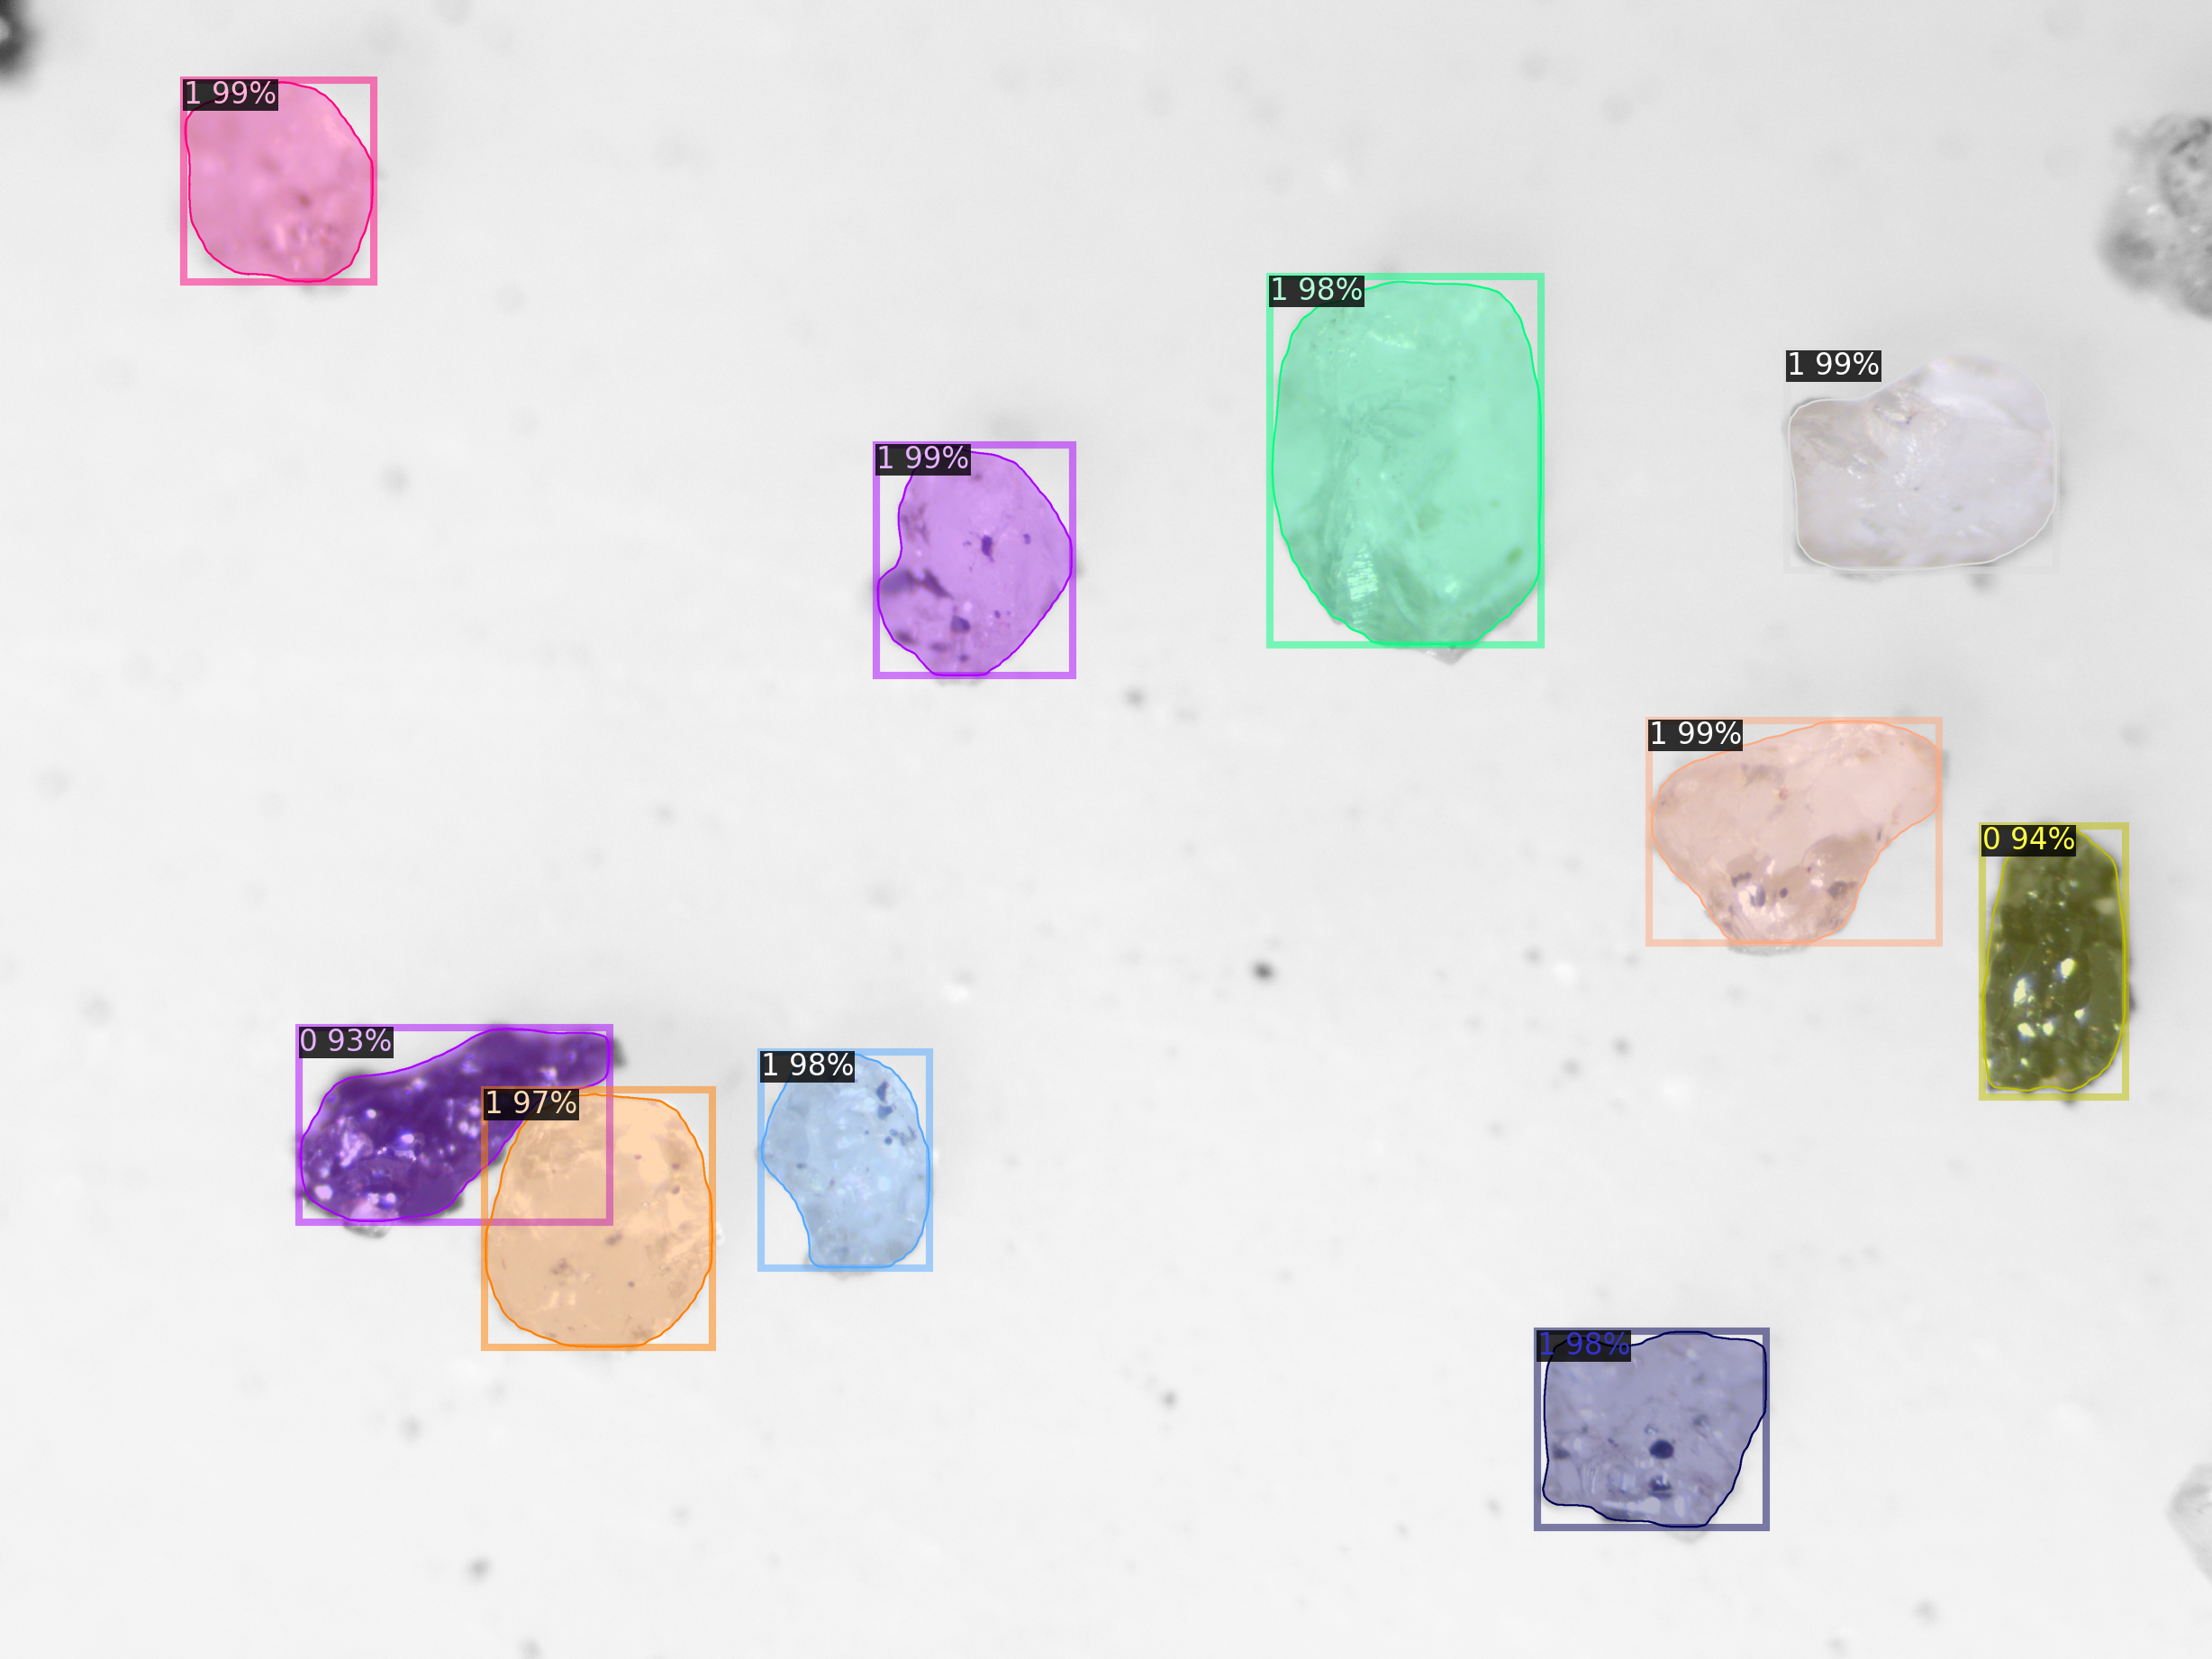

In [ ]:
%%time
#fazer inferencia individual
if inferenceCfg['register']:
  if inferenceCfg['inferencer'] is None:
    inferencer = InFerenceProcess(inferenceCfg)
    inferenceCfg['inferencer'] = inferencer
    print('Inferencer Created')
  else:
    print('Inferencer already Created')
    inferencer = inferenceCfg['inferencer']

  #inferencer.runOneInference(inferenceCfg)
  inferencer.runOneInference(inferenceCfg, newFilename = '0205.png')
else:
  print('Sem inferencia individual')


# Executar Treinamento?

In [ ]:
%%time
#Configurar para fazer um treinamento
if trainModelCfg['register']:
    trainProc = TrainProcess()
    trainProc.runTrain(trainModelCfg)
else:
  print('Sem treinamento')

Sem treinamento
CPU times: user 42 µs, sys: 9 µs, total: 51 µs
Wall time: 54.4 µs


# Executar Testes?

In [ ]:
%%time
# Configuração básica para inferência de um lote de imagens registradas no catálogo
if testModelCfg['register']:
  testProc = TestProcess()
  testProc.runTest(testModelCfg)
else:
  print('Sem teste')

Sem teste
CPU times: user 48 µs, sys: 0 ns, total: 48 µs
Wall time: 51.7 µs


In [ ]:
#Calcular Grau de liberação Mineral

# Executar cálculo do grau de liberação

In [ ]:
manyImages =  ['0201.png', '0202.png', '0203.png', '0204.png', '0205.png', '0206.png', '0207.png', '0208.png', '0209.png', '0210.png', '0211.png', '0212.png', '0213.png', '0214.png', '0215.png', '0216.png', '0217.png', '0218.png', '0220.png', '0222.png', '0223.png', '0224.png', '0225.png', '0226.png', '0227.png', '0228.png', '0229.png', '0230.png', '0231.png', '0232.png', '0233.png', '0234.png', '0235.png', '0236.png', '0237.png', '0238.png', '0239.png', '0240.png', '0241.png', '0242.png', '0243.png', '0244.png', '0245.png', '0246.png', '0247.png', '0250.png', '0251.png', '0253.png', '0256.png', '0258.png', '0259.png', '0260.png', '0261.png', '0262.png', '0263.png', '0264.png', '0265.png', '0266.png', '0267.png', '0269.png']

imageName= 0223.png

Segmento 0
(970, 764)


total de segmentos:  509
Media geral da Imagem: 0.8920799938334129
Quantidade de cor escura: 0.9252815386562064 %
Threshold: 0.55
Segments: [217, 219, 379]


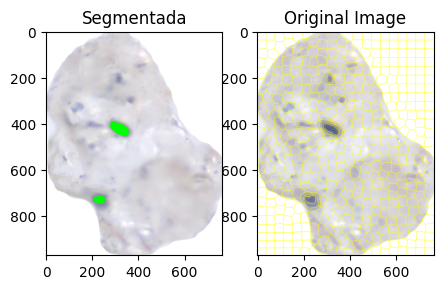


Segmento 1
(1247, 771)


total de segmentos:  476
Media geral da Imagem: 0.8772246263373422
Quantidade de cor escura: 0.238118517738551 %
Threshold: 0.55
Segments: [250]


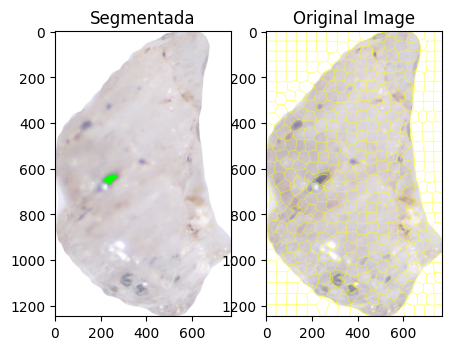


Segmento 2
(501, 498)


total de segmentos:  521
Media geral da Imagem: 0.8612175758727446
Quantidade de cor escura: 2.780729902906611 %
Threshold: 0.55
Segments: [71, 114, 115, 116, 117, 197, 202, 204, 205, 226, 227, 324]


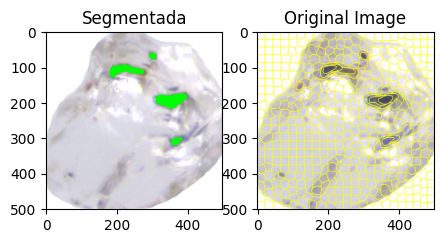


Segmento 3
(616, 750)
total de segmentos:  509
Media geral da Imagem: 0.8633810825340233
Quantidade de cor escura: 0.9339855828136923 %
Threshold: 0.55
Segments: [238, 288, 299, 301, 342]


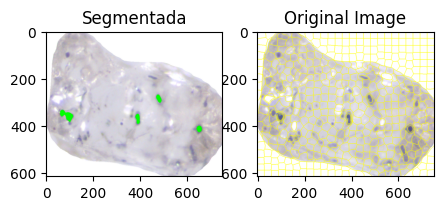


Segmento 4
(618, 500)


total de segmentos:  478
Media geral da Imagem: 0.5638539881972205
Quantidade de cor escura: 92.6139038313003 %
Threshold: 0.55
Segments: [9, 10, 21, 22, 23, 25, 26, 27, 34, 39, 42, 44, 45, 46, 48, 52, 54, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 94, 96, 97, 98, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 222, 223, 224, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 238, 239, 240, 241, 242, 243

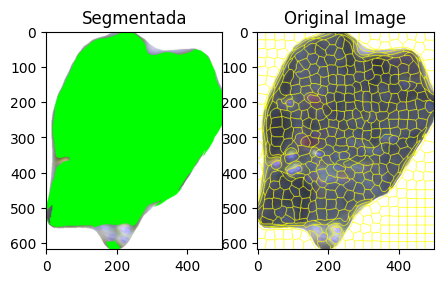


Segmento 5
(497, 755)


total de segmentos:  499
Media geral da Imagem: 0.8331678614299308
Quantidade de cor escura: 7.6754779825950665 %
Threshold: 0.55
Segments: [192, 193, 194, 197, 198, 200, 201, 202, 212, 220, 222, 223, 227, 231, 242, 248, 249, 267, 276, 279, 283, 286, 299, 301, 306, 312, 313, 330, 333, 370, 384, 408, 473]


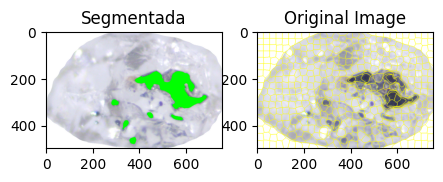

Segmento 0: 1 (0.009252815386562065)
Segmento 1: 1 (0.00238118517738551)
Segmento 2: 1 (0.027807299029066108)
Segmento 3: 1 (0.009339855828136923)
Segmento 4: 20.0 (0.926139038313003)
Segmento 5: 1.5350955965190134 (0.07675477982595066)

Total Particulas no cálculo: 6
Grau de liberação: 20.0 / 25.535095596519014 = 0.7832357597567182
 Tempo decorrido: 0:00:46.149664 
 Inicio: 2024-04-13 17:08:15.891010 
 Fim: 2024-04-13 17:09:02.040674 
#########################

/content/gdrive/MyDrive/detectron2/mestrado/output/resultados/i201_269s500t0_1a70_0.json
cp Detectron2MineracaoExperimento.ipynb Detectron2MineracaoExperimento_i201_269s500t0_1a70_0.json.ipynb
2024-04-13 14:09:03.980156-03:00
CPU times: user 42.8 s, sys: 2.06 s, total: 44.8 s
Wall time: 48.1 s


In [ ]:
%%time
#                 0      1       2    3
minValues =   [0.0005, 0.001, 0.002, 0.01]
minValue = 1
maxValue = 0.70 # [0.75, 0.80, 0.85, 0.90]
showImages = True
segmentImageSlic201_269(inferenceCfg, minValues[minValue], maxValue, manyImages, inferencer, DRIVE_ROOT_DIR, showImages )

In [ ]:
%%time
maxValue = 0.75 #  0.80, 0.85, 0.90
segmentImageSlic201_269(inferenceCfg, minValues[minValue], maxValue, manyImages, inferencer, DRIVE_ROOT_DIR, showImages )

In [ ]:
%%time
maxValue = 0.80 #  0.85, 0.90
#showImages = False
segmentImageSlic201_269(inferenceCfg, minValues[minValue], maxValue, manyImages, inferencer, DRIVE_ROOT_DIR, showImages )

In [ ]:
%%time
maxValue = 0.85 # 0.90
#showImages = False
segmentImageSlic201_269(inferenceCfg, minValues[minValue], maxValue, manyImages, inferencer, DRIVE_ROOT_DIR, showImages )

In [ ]:
%%time
maxValue = 0.90
#showImages = False
segmentImageSlic201_269(inferenceCfg, minValues[minValue], maxValue, manyImages, inferencer, DRIVE_ROOT_DIR, showImages )

# FIM